# Jun 28th, 2022 (Carto not working: 512)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def plot_cartography(
    df: pd.DataFrame,
    palette: Dict[str, str],
    xlim: Tuple[float, float] = None,
    ylim: Tuple[float, float] = None,
    hue: str = 'oc_idx',
    grid: bool = True,
    display: bool = True,
    leg_size: float = 14,
    size: float = 7,
    scatter_kws: dict = None,
    density_kws: dict = None,
    median_kws: dict = None, ):
    
    scatter_kws = scatter_kws if scatter_kws else {
        's': 120,
        'alpha': 0.9,
        'edgecolor': 'dimgrey',
    }
    density_kws = density_kws if density_kws else {
        'lw': 2,
        'fill': True,
        'alpha': 0.5,
    }
    median_kws = median_kws if median_kws else {
        'lw': 1.5,
        'ls': '--',
        'zorder': 0,
        'alpha': 1.0,
        'c': sns.color_palette('deep')[7],
    }
    
    set_style('ticks')
    jg = sns.JointGrid(
        data=df,
        x='entropy',
        y='degree',
        hue=hue,
        size=size,
        palette=palette,
        xlim=xlim,
        ylim=ylim,
        space=0.0,
    )
    # joint: scatter
    jg.plot_joint(
        sns.scatterplot,
        hue=hue,
        **scatter_kws,
    )
    # margnials: density
    jg.plot_marginals(
        sns.kdeplot,
        **density_kws,
    )
    # medians
    for name in ['entropy', 'degree']:
        x = df[name].median()
        lbl = f"median {name}: {x:.2f}"
        if name == 'entropy':
            jg.refline(x=x, label=lbl, **median_kws)
        else:
            jg.refline(y=x, label=lbl, **median_kws)
    # legend
    jg.ax_joint.legend(loc='upper left', prop={'size': leg_size})
    leg = jg.ax_joint.get_legend()
    if leg is not None:
        plt.setp(leg, bbox_to_anchor=(1.3, 1.0))
    
    if grid:
        jg.ax_joint.grid()
    
    if display:
        plt.show()
    else:
        plt.close()
    return jg

## Prepare (512)

In [3]:
mice = Mice(512)

_BOLD = 'BOLD'
_CAS = r'Ca$^{2\!\!+}$' + ' (slow)'
_CAF = r'Ca$^{2\!\!+}$' + ' (fast)'
mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {_BOLD: rocket(0.6), _CAS: mako(0.6), _CAF: to_rgb('C8')} # mako(0.3)}

In [4]:
task = 'rest'

num_k, p = 10, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bs = Base(**props_ca)
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

## How mu = 0.003, alpha = 0.05 looks: raw vs. prune

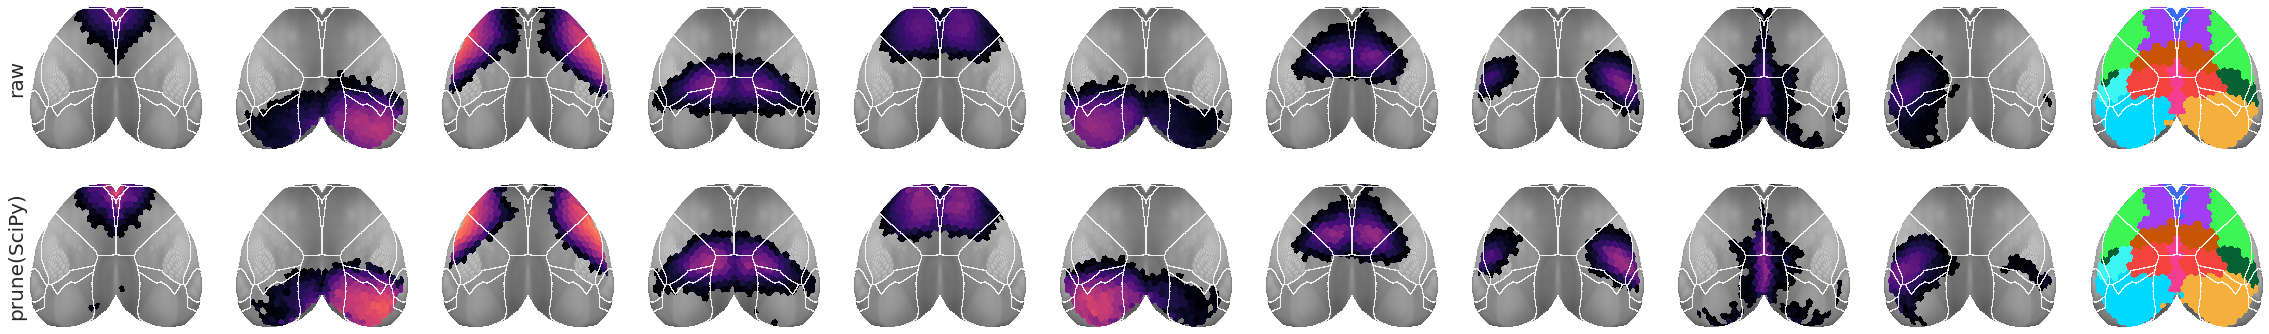

In [5]:
_ = bs.show(
    data={'raw': avg(bt_bo.run_pi), 'prune(SciPy)': avg(bt_bo.pi_prune)},
    figsize=(40, 6),
    ylabel_fontsize=20,
)

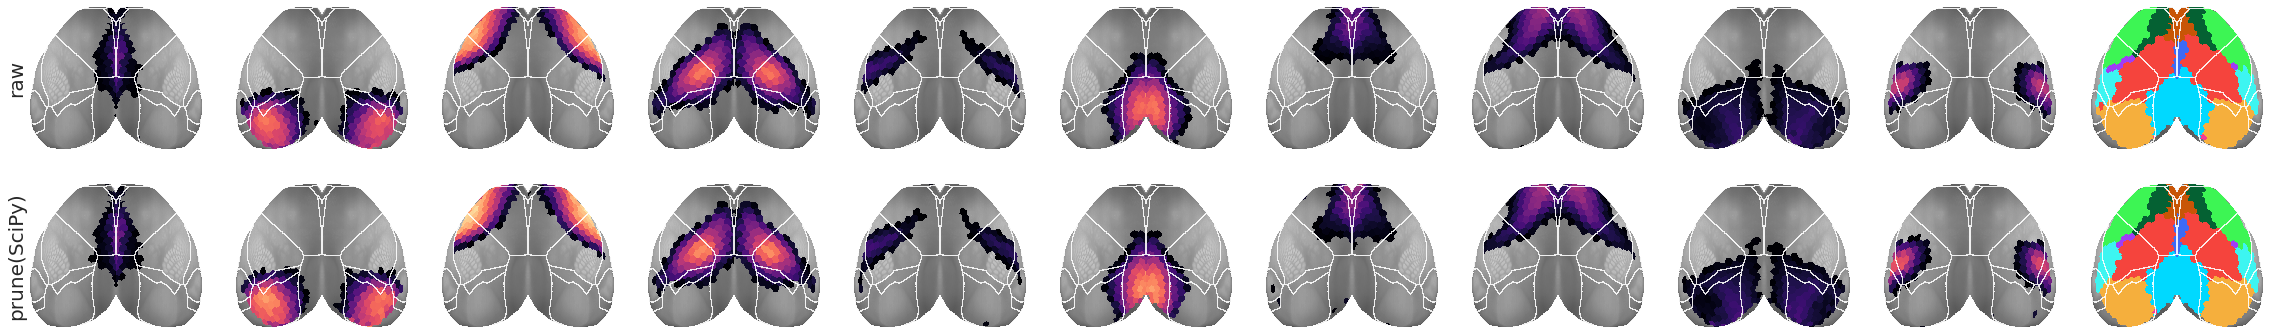

In [6]:
_ = bs.show(
    data={'raw': avg(bt_cas.run_pi), 'prune(SciPy)': avg(bt_cas.pi_prune)},
    figsize=(40, 6),
    ylabel_fontsize=20,
)

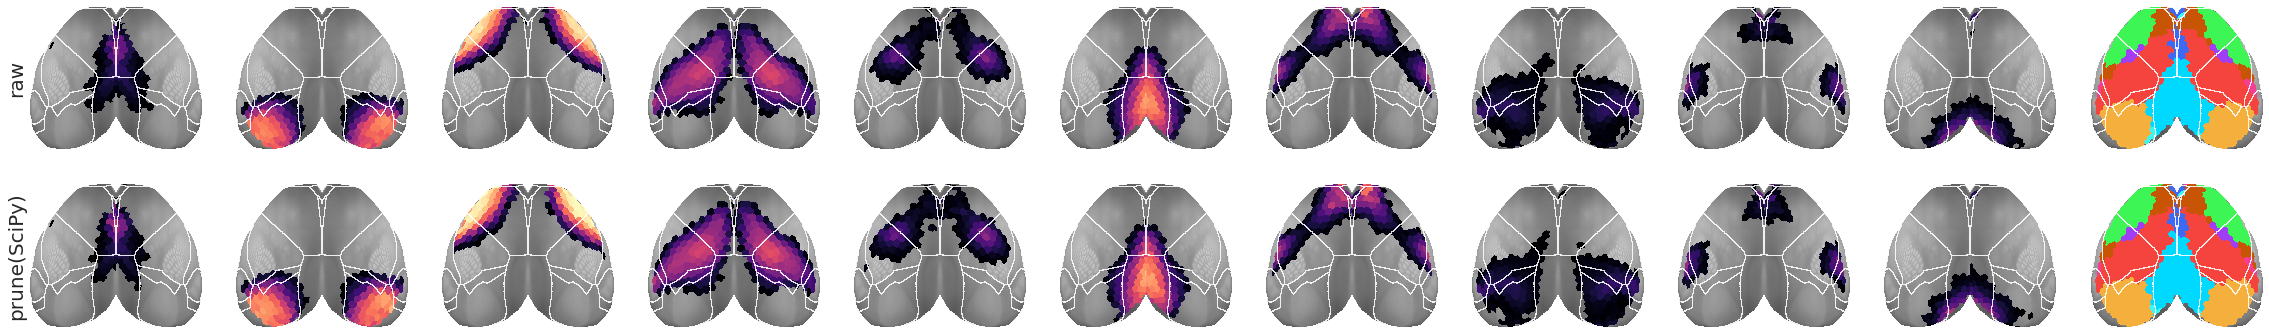

In [7]:
_ = bs.show(
    data={'raw': avg(bt_caf.run_pi), 'prune(SciPy)': avg(bt_caf.pi_prune)},
    figsize=(40, 6),
    ylabel_fontsize=20,
)

In [8]:
[e[-1] for e in bs.pi_symmetry_score(avg(bt_cas.pi_prune))]

[0.971, 0.982]

In [9]:
[e[-1] for e in bs.pi_symmetry_score(avg(bt_cas.run_pi))]

[0.98, 0.976]

## Members: various $\mu$

In [10]:
se, f = bt_bo.fit_boot(n_resamples=int(1e5))
f

'se-BCa_group-pi_1.0e+05'

In [11]:
pi = avg(bt_bo.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

mu_vals = [0.05] + [i / bt_bo.num_k for i in [1, 3, 5]]
for mu in mu_vals:
    reject, pvals = bt_bo.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

mu_vals

[0.05, 0.1, 0.3, 0.5]

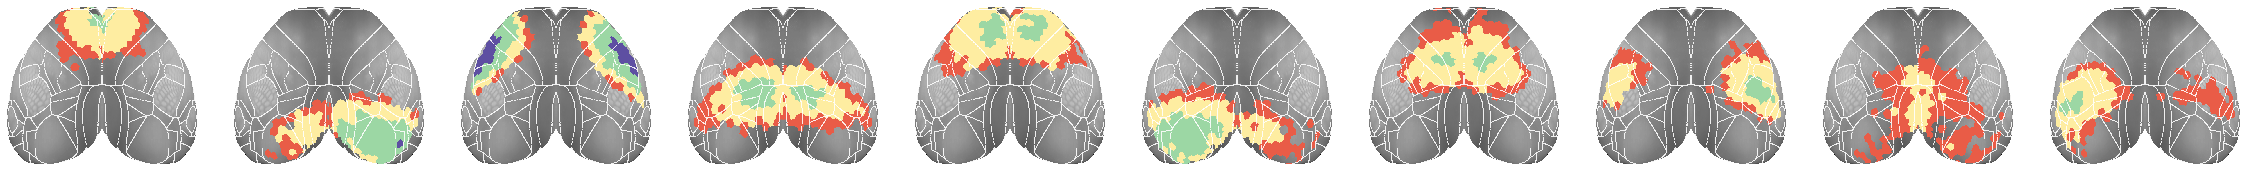

In [12]:
_ = bs.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    coarse=False,
    width=0.001,
    add_disjoint=False,
    figsize=(40, 8),
)

In [13]:
se, f = bt_cas.fit_boot(n_resamples=int(1e5))
f

'se-BCa_group-pi_1.0e+05'

In [14]:
pi = avg(bt_cas.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

mu_vals = [0.05] + [i / bt_cas.num_k for i in [1, 3, 5]]
for mu in mu_vals:
    reject, pvals = bt_cas.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

mu_vals

[0.05, 0.1, 0.3, 0.5]

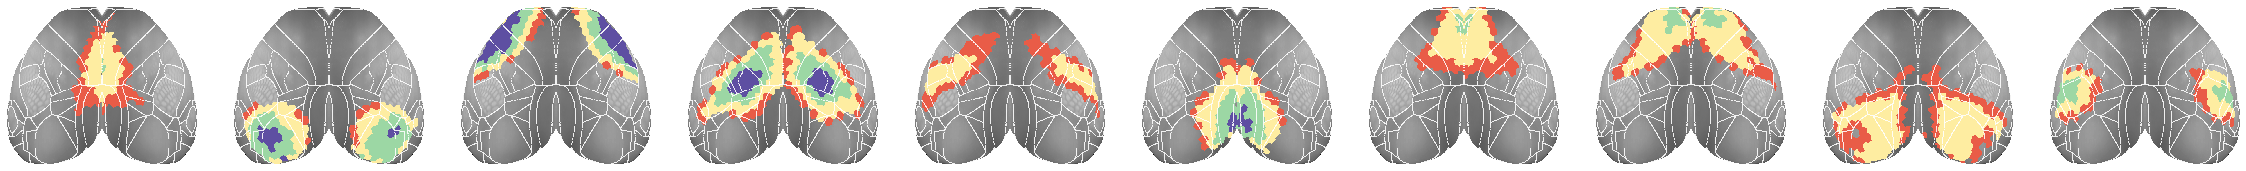

In [15]:
_ = bs.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    coarse=False,
    width=0.001,
    add_disjoint=False,
    figsize=(40, 8),
)

In [16]:
se, f = bt_caf.fit_boot(n_resamples=int(1e5))
f

'se-BCa_group-pi_1.0e+05'

In [17]:
pi = avg(bt_caf.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

mu_vals = [0.05] + [i / bt_caf.num_k for i in [1, 3, 5]]
for mu in mu_vals:
    reject, pvals = bt_caf.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

mu_vals

[0.05, 0.1, 0.3, 0.5]

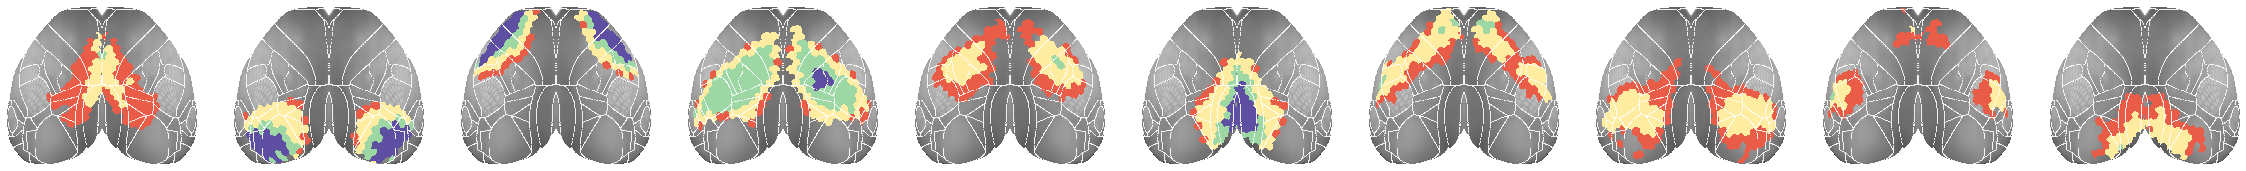

In [18]:
_ = bs.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    coarse=False,
    width=0.001,
    add_disjoint=False,
    figsize=(40, 8),
)

## Explore degree a bit

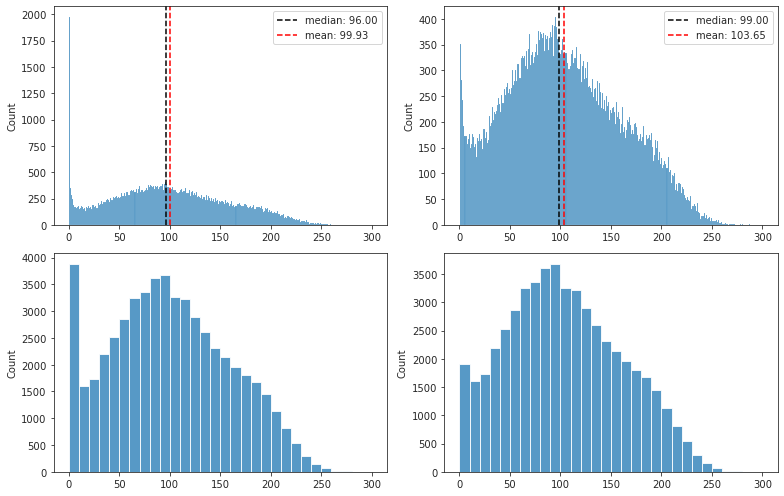

In [19]:
fig, axes = create_figure(2, 2, (11, 7))

bins = np.linspace(0, 300, 301)
sns.histplot(bt_cas.run_deg[np.isfinite(bt_cas.run_deg)], bins=bins, ax=axes[0, 0])
sns.histplot(bt_cas.run_deg[np.nonzero(bt_cas.run_deg)], bins=bins, ax=axes[0, 1])

bins = np.linspace(0, 300, 31)
sns.histplot(bt_cas.run_deg[np.isfinite(bt_cas.run_deg)], bins=bins, ax=axes[1, 0])
sns.histplot(bt_cas.run_deg[np.nonzero(bt_cas.run_deg)], bins=bins, ax=axes[1, 1])

_x = np.nanmedian(bt_cas.run_deg[np.isfinite(bt_cas.run_deg)])
axes[0, 0].axvline(_x, color='k', ls='--', label=f'median: {_x:0.2f}')
_x = np.nanmean(bt_cas.run_deg[np.isfinite(bt_cas.run_deg)])
axes[0, 0].axvline(_x, color='r', ls='--', label=f'mean: {_x:0.2f}')
    
_x = np.nanmedian(bt_cas.run_deg[np.nonzero(bt_cas.run_deg)])
axes[0, 1].axvline(_x, color='k', ls='--', label=f'median: {_x:0.2f}')
_x = np.nanmean(bt_cas.run_deg[np.nonzero(bt_cas.run_deg)])
axes[0, 1].axvline(_x, color='r', ls='--', label=f'mean: {_x:0.2f}')
    
for ax in axes[0].flat:
    ax.legend()
    
plt.show()

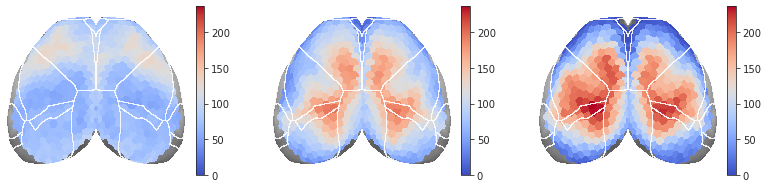

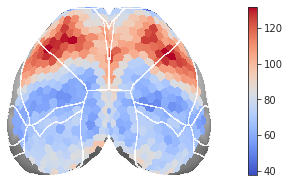

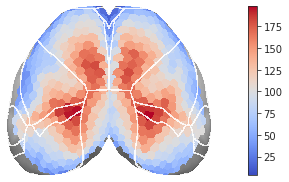

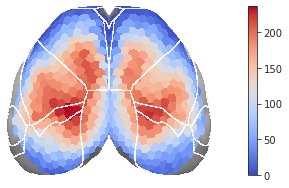

In [20]:
deg = np.concatenate([
    np.expand_dims(avg(bt_bo.run_deg, 1), 0),
    np.expand_dims(avg(bt_cas.run_deg, 1), 0),
    np.expand_dims(avg(bt_caf.run_deg, 1), 0),
])
_ = bs.show(
    data=deg,
    figsize=(13.5, 3.1),
    vmin=np.nanmin(deg),
    vmax=np.nanmax(deg),
    mask_thresh=0.001,
    add_disjoint=False,
    cmap='coolwarm',
    cbar=True,
)
for i in range(3):
    _ = bs.show(
        data=deg[i],
        figsize=(13.5, 3.1),
        vmin=np.nanmin(deg[i]),
        vmax=np.nanmax(deg[i]),
        mask_thresh=0.001,
        add_disjoint=False,
        cmap='coolwarm',
        cbar=True,
    )

### See if mega animal helps (deg)

In [32]:
x = 'sub-SLC_task-rest_space-CCF3d_bold.npy'
x = pjoin(mice.cfg.bold_dir, x)
x = np.load(x)

In [36]:
a, p = get_adj_mat(x, 'pearson')

<matplotlib.colorbar.Colorbar object at 0x7f390c11f0d0>

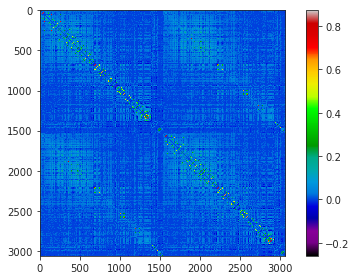

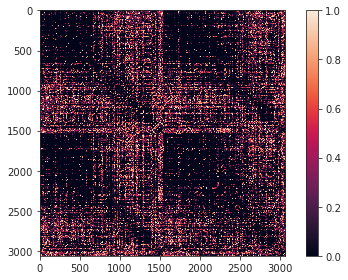

In [42]:
create_figure()
plt.imshow(a, cmap='nipy_spectral')
plt.colorbar()

create_figure()
plt.imshow(p)
plt.colorbar()

<AxesSubplot:ylabel='Count'>

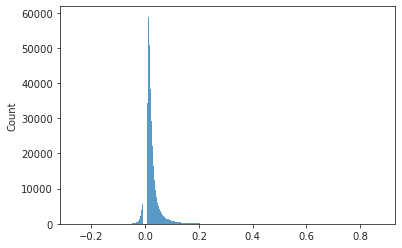

In [43]:
sns.histplot(a[a.nonzero()])

In [44]:
b = a.copy()
b[b < 0] = 0

<matplotlib.colorbar.Colorbar object at 0x7f38b303ffd0>

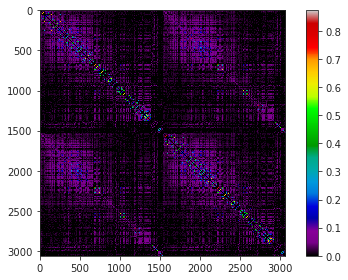

In [45]:
create_figure()
plt.imshow(b, cmap='nipy_spectral')
plt.colorbar()

In [60]:
rho = [0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35]
thresholds = calculate_threshold(b, rho, verbose=True)
thresholds = dict(zip(rho, thresholds))

threshold = 0.064   /   density:  requested = 0.05000, result = 0.05000;

threshold = 0.043   /   density:  requested = 0.10000, result = 0.10000;

threshold = 0.034   /   density:  requested = 0.15000, result = 0.15000;

threshold = 0.028   /   density:  requested = 0.20000, result = 0.20000;

threshold = 0.024   /   density:  requested = 0.25000, result = 0.25000;

threshold = 0.021   /   density:  requested = 0.30000, result = 0.30000;

threshold = 0.019   /   density:  requested = 0.35000, result = 0.35000;

In [62]:
c = b.copy()
c[c <= thresholds[0.25]] = 0

In [63]:
g = nx.from_numpy_matrix(c)
nx.density(g)

0.25000005334595427

<matplotlib.legend.Legend object at 0x7f3897d55460>

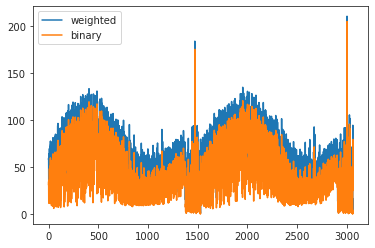

In [66]:
deg_binary = c.sum(0)
deg_weighted = b.sum(0)

plt.plot(deg_weighted, label='weighted')
plt.plot(deg_binary, label='binary')
plt.legend()

In [68]:
bs2 = Base(mice=mice, mode='bold')

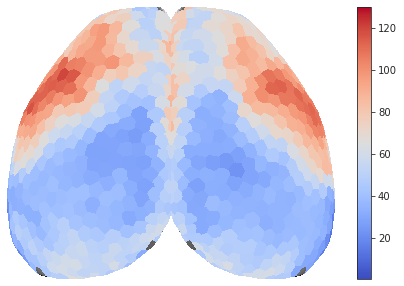

In [82]:
_ = bs2.show(
    data=deg_binary,
    vmin=deg_binary.min(),
    vmax=130,
    figsize=(8, 5),
    contour=False,
    cbar=True,
    cmap='coolwarm',
    add_disjoint=False,
)

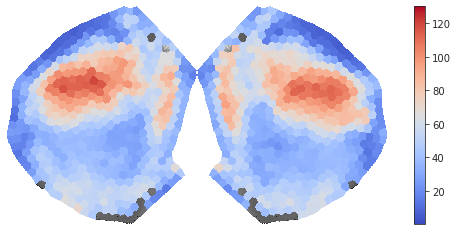

In [84]:
_ = bs2.show(
    data=deg_binary,
    vmin=deg_binary.min(),
    vmax=130,
    figsize=(10, 4),
    contour=False,
    cbar=True,
    cmap='coolwarm',
    proj='flat',
    add_disjoint=False,
)

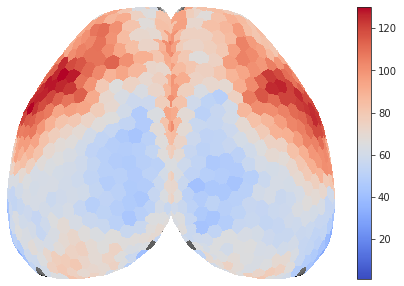

In [87]:
_ = bs2.show(
    data=deg_weighted,
    vmin=deg_weighted.min(),
    vmax=130,
    figsize=(8, 5),
    contour=False,
    cbar=True,
    cmap='coolwarm',
    add_disjoint=False,
)

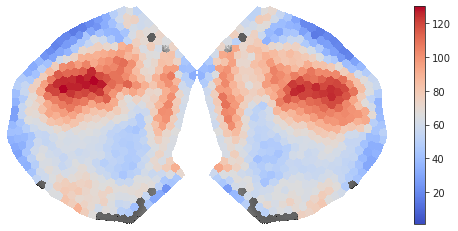

In [88]:
_ = bs2.show(
    data=deg_weighted,
    vmin=deg_weighted.min(),
    vmax=130,
    figsize=(10, 4),
    contour=False,
    cbar=True,
    cmap='coolwarm',
    proj='flat',
    add_disjoint=False,
)

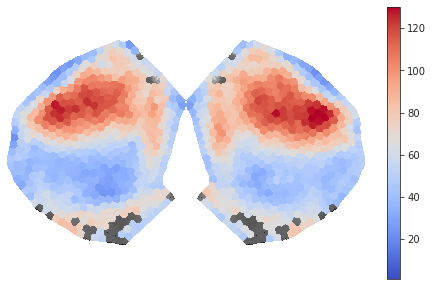

In [97]:
_ = bs2.show(
    data=deg_weighted,
    vmin=deg_weighted.min(),
    vmax=130,
    layer=1,
    proj='flat',
    figsize=(8, 5),
    contour=False,
    cbar=True,
    cmap='coolwarm',
    add_disjoint=False,
)

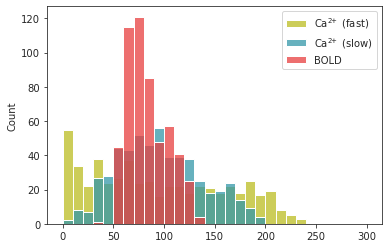

In [19]:
bins = np.linspace(0, 300, 31)
sns.histplot(avg(bt_caf.run_deg, 1), color=pal[_CAF], bins=bins, label=_CAF)
sns.histplot(avg(bt_cas.run_deg, 1), color=pal[_CAS], bins=bins, label=_CAS)
sns.histplot(avg(bt_bo.run_deg, 1), color=pal[_BOLD], bins=bins, label=_BOLD)
plt.legend();

In [20]:
%%time

df = []
for mode, bt in {_BOLD: bt_bo, _CAS: bt_cas, _CAF: bt_caf}.items():
    _df = bt.mk_cartography_df(affil=bs.affil_included)
    _df['mode'] = mode
    df.append(_df)
df = pd.concat(df, axis=0)

CPU times: user 3min 42s, sys: 1 s, total: 3min 43s
Wall time: 3min 43s


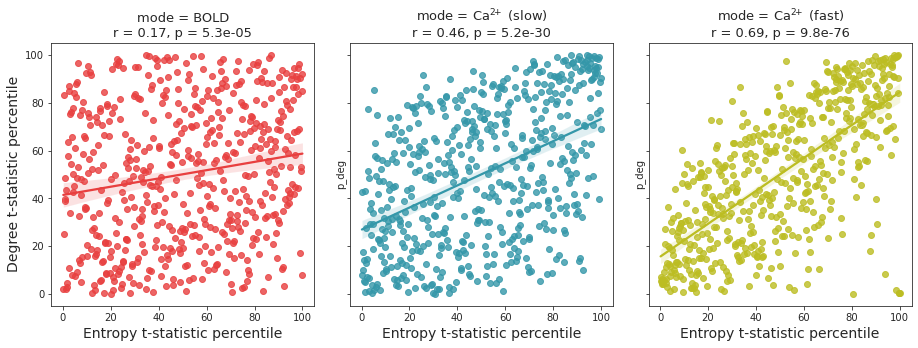

In [21]:
fig, axes = create_figure(1, 3, (13, 4.5), 'all', 'all')

for ax, mode in zip(axes.flat, df['mode'].unique()):
    _df = df.loc[df['mode'] == mode]
    good = np.logical_and(np.isfinite(_df['p_ent']), np.isfinite(_df['p_deg']))
    pearson_r, pval = sp_stats.pearsonr(_df['p_ent'][good], _df['p_deg'][good])
    title = f"mode = {mode}\n"
    title += f"r = {pearson_r:0.2f}, p = {pval:0.2g}"
    
    sns.regplot(_df['p_ent'][good], _df['p_deg'][good], color=pal[mode], ax=ax)
    ax.set_title(title, fontsize=13)
    ax.set_aspect('equal')
    ax.set_xlabel('Entropy t-statistic percentile', fontsize=14)
axes[0].set_ylabel('Degree t-statistic percentile', fontsize=14)
plt.show()

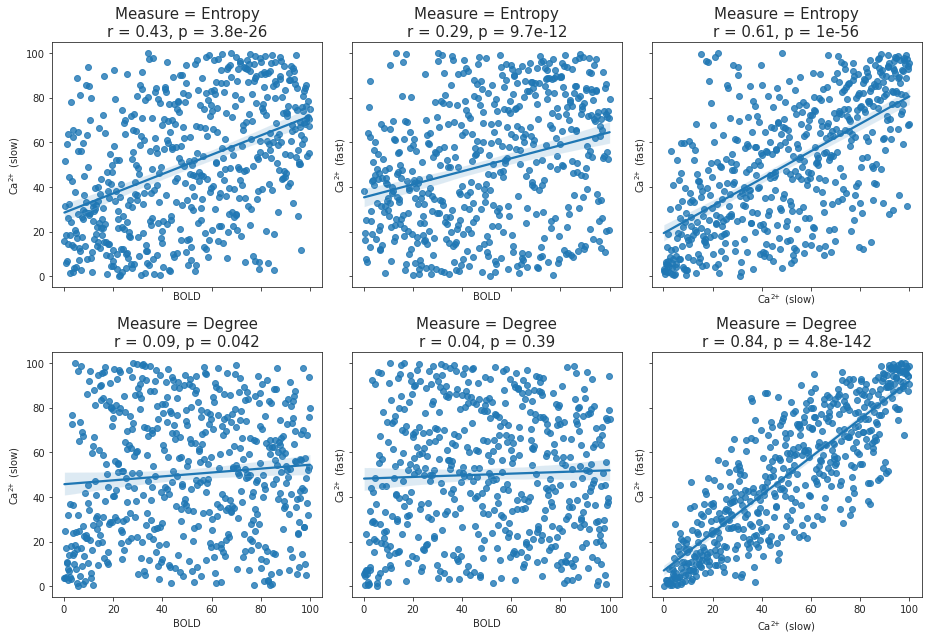

In [22]:
fig, axes = create_figure(2, 3, (13, 9), 'all', 'all')

for i, (mode1, mode2) in enumerate(itertools.combinations(pal, 2)):
    _df1 = df.loc[df['mode'] == mode1]
    _df2 = df.loc[df['mode'] == mode2]
    
    ax = axes[0, i]
    good = np.logical_and(
        np.isfinite(_df1['p_ent']),
        np.isfinite(_df2['p_ent']),
    )
    pearson_r, pval = sp_stats.pearsonr(
        _df1['p_ent'][good],
        _df2['p_ent'][good],
    )
    title = f"Measure = Entropy\n"
    title += f"r = {pearson_r:0.2f}, p = {pval:0.2g}"
    ax.set_title(title, fontsize=15)
    sns.regplot(_df1['p_ent'], _df2['p_ent'], ax=ax)
    
    ax.set_xlabel(mode1)
    ax.set_ylabel(mode2)

    
    ax = axes[1, i]
    good = np.logical_and(
        np.isfinite(_df1['p_deg']),
        np.isfinite(_df2['p_deg']),
    )
    pearson_r, pval = sp_stats.pearsonr(
        _df1['p_deg'][good],
        _df2['p_deg'][good],
    )
    title = f"Measure = Degree\n"
    title += f"r = {pearson_r:0.2f}, p = {pval:0.2g}"
    ax.set_title(title, fontsize=15)
    sns.regplot(_df1['p_deg'], _df2['p_deg'], ax=ax)
    
    ax.set_xlabel(mode1)
    ax.set_ylabel(mode2)

plt.show()

In [23]:
xy = {
    k: np.concatenate([
        np.expand_dims(df.loc[df['mode'] == k, 'p_ent'].values, 0),
        np.expand_dims(df.loc[df['mode'] == k, 'p_deg'].values, 0),
    ]) for k in df['mode'].unique()
}

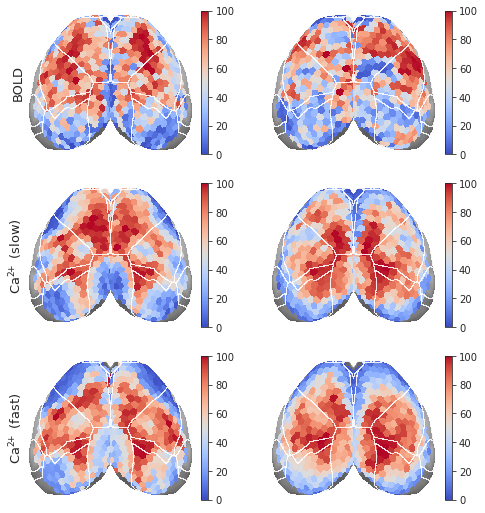

In [24]:
_ = bs.show(
    data=xy,
    figsize=(8, 9),
    vmin=0,
    vmax=100,
    mask_thresh=0.00001,
    add_disjoint=False,
    cmap='coolwarm',
    cbar=True,
)

In [25]:
delta = {
    f"{k1}_vs_{k2}": np.linalg.norm(xy[k1] - xy[k2], ord=2, axis=0)
    for k1, k2 in itertools.combinations(xy, 2)
}
delta = {k: v / np.linalg.norm([200], ord=2) for k, v in delta.items()}

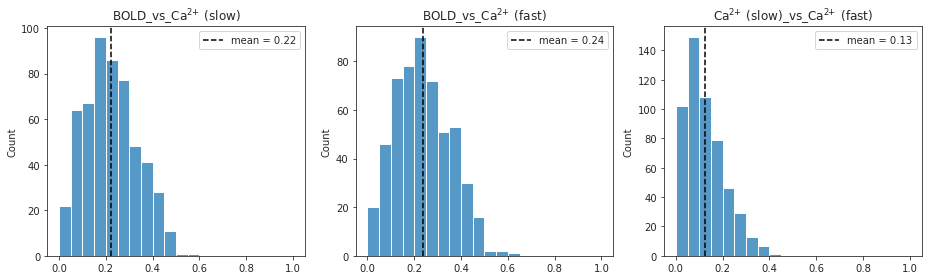

In [26]:
fig, axes = create_figure(1, 3, (13, 4))
for ax, (k, v) in zip(axes.flat, delta.items()):
    sns.histplot(v, bins=np.linspace(0, 1, 21), ax=ax)
    ax.axvline(bn.nanmean(v), color='k', ls='--', label=f"mean = {bn.nanmean(v):0.2g}")
    ax.set_title(k)
    ax.legend()
plt.show()

In [27]:
vmin = np.nanmin([np.nanmin(v) for v in delta.values()])
vmax = np.nanmax([np.nanmax(v) for v in delta.values()])
vmin, vmax

(0.000853239535308123, 0.6033554533161221)

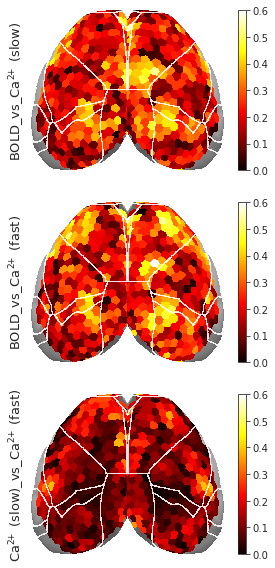

In [28]:
_ = bs.show(
    data=delta,
    vmin=0,
    vmax=0.6,
    mask_thresh=0.0001,
    thres=-np.inf,
    cmap='hot',
    cbar=True,
    add_disjoint=False,
    figsize=(5, 10),
)

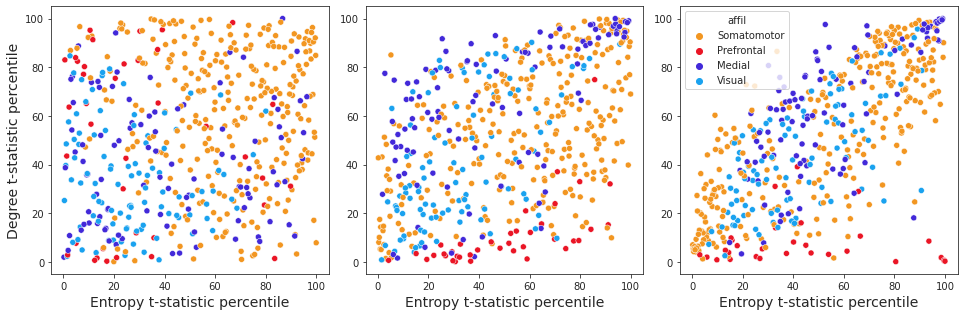

In [29]:
fig, axes = create_figure(1, 3, (13.5, 4.5))

for ax, mode in zip(axes.flat, df['mode'].unique()):
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['affil'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='p_ent',
        y='p_deg',
        hue='affil',
        palette=bs.affil['colors'],
        legend=True if mode == list(pal)[-1] else False,
        ax=ax,
    )
    ax.set_ylabel('')
    ax.set_xlabel('Entropy t-statistic percentile', fontsize=14)
axes[0].set_ylabel('Degree t-statistic percentile', fontsize=14)
plt.show()

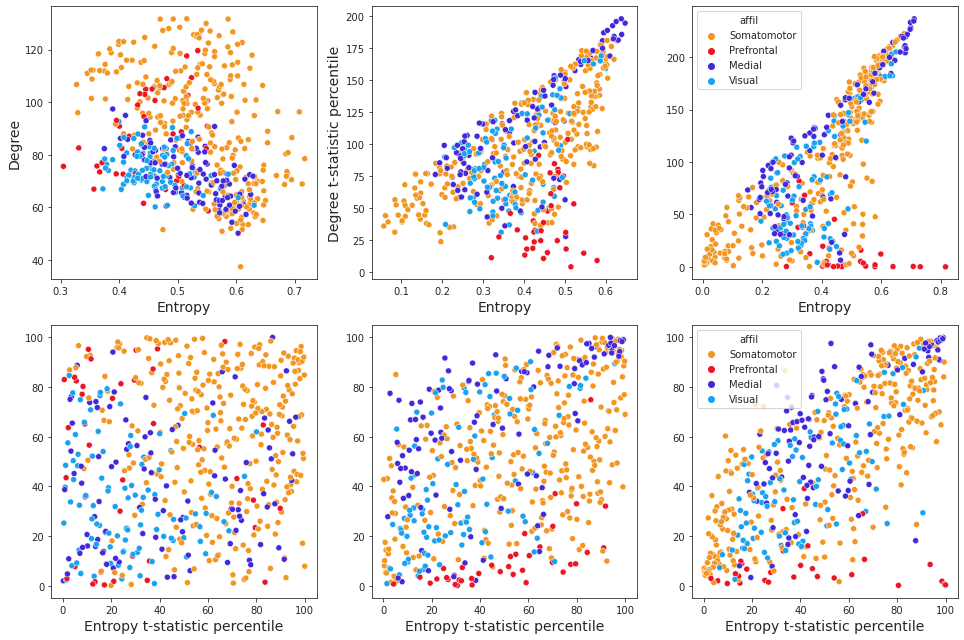

In [30]:
fig, axes = create_figure(2, 3, (13.5, 9))

for i, mode in enumerate(df['mode'].unique()):
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['affil'].isin(['Auditory', 'Lateral']))
    ]
    ax = axes[0, i]
    sns.scatterplot(
        data=_df,
        x='ent',
        y='deg',
        hue='affil',
        palette=bs.affil['colors'],
        legend=True if mode == list(pal)[-1] else False,
        ax=ax,
    )
    ax.set_ylabel('')
    ax.set_xlabel('Entropy', fontsize=14)
    
    ax = axes[1, i]
    sns.scatterplot(
        data=_df,
        x='p_ent',
        y='p_deg',
        hue='affil',
        palette=bs.affil['colors'],
        legend=True if mode == list(pal)[-1] else False,
        ax=ax,
    )
    ax.set_ylabel('')
    ax.set_xlabel('Entropy t-statistic percentile', fontsize=14)
    
axes[0, 0].set_ylabel('Degree', fontsize=14)
axes[0, 1].set_ylabel('Degree t-statistic percentile', fontsize=14)
plt.show()

In [31]:
list(bs.affil)

[
    'cmap',
    'colors',
    'obj_top',
    'obj_flat',
    'aff_top',
    'aff_flat',
    'regions_l',
    'regions_r',
    'affiliation',
    'regions_affil',
    'regions_affil_max'
]

In [32]:
a = bs.affil['obj_top'].copy()
for i, idx in enumerate(np.unique(a[a.nonzero()])):
    a[a == idx] = i + 1

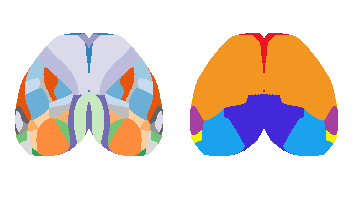

In [33]:
fig, axes = create_figure(1, 2, (5, 3))
axes[0].imshow(mwh(a == 0, a), cmap='tab20c')
axes[1].imshow(mwh(bs.affil['aff_top'] == 0, bs.affil['aff_top']), cmap=bs.affil['cmap'])
remove_ticks(axes)
plt.show()

## Explore entropy a little

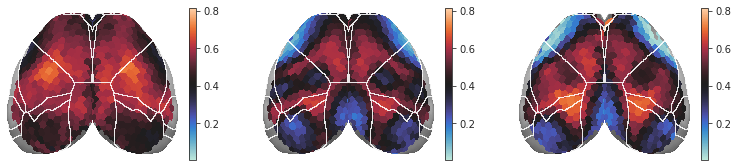

In [65]:
a = np.concatenate([
    np.expand_dims(df.loc[df['mode'] == k, 'ent'].values, 0)
    for k in df['mode'].unique()
])
_ = bs.show(
    data=a,
    figsize=(13, 2.8),
    vmin=np.nanmin(a),
    vmax=np.nanmax(a),
    mask_thresh=1e-20,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

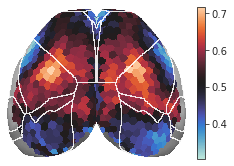

In [67]:
_ = bs.show(
    data=a[0],
    figsize=(4, 2.8),
    vmin=np.nanmin(a[0]),
    vmax=np.nanmax(a[0]),
    mask_thresh=1e-20,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

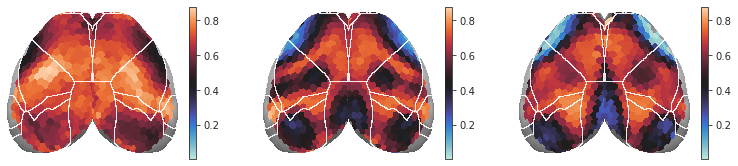

In [68]:
b = np.concatenate([
    np.expand_dims(sp_stats.entropy(avg(bt_bo.pi_prune), axis=-2), 0),
    np.expand_dims(sp_stats.entropy(avg(bt_cas.pi_prune), axis=-2), 0),
    np.expand_dims(sp_stats.entropy(avg(bt_caf.pi_prune), axis=-2), 0),
]) / np.log(num_k)
_ = bs.show(
    data=b,
    figsize=(13, 2.8),
    vmin=np.nanmin(b),
    vmax=np.nanmax(b),
    mask_thresh=1e-20,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

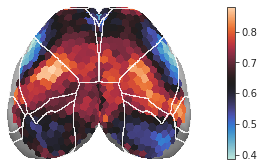

In [69]:
b = sp_stats.entropy(avg(bt_bo.pi_prune), axis=-2) / np.log(num_k)
_ = bs.show(
    data=b,
    figsize=(13, 2.8),
    vmin=np.nanmin(b),
    vmax=np.nanmax(b),
    mask_thresh=1e-20,
    add_disjoint=False,
    cmap='icefire',
    cbar=True,
)

<AxesSubplot:>

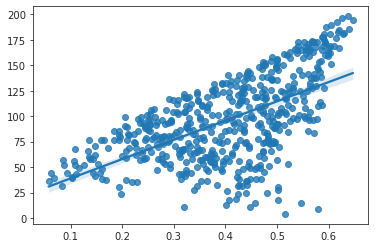

In [70]:
sns.regplot(a[1], avg(bt_cas.run_deg, 1))